In [3]:
# Install igraph
!pip install igraph

# move to the directory where the foodweb graphs are located.
import os
import itertools


# importing libraries
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
from collections import Counter

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle

# display plots in the notebook
%matplotlib inline
from matplotlib import rcParams

WORKING_DIR = '.'
OUT_FOLDER_PAPER = './Paper'
OUT_FOLDER_SUPP = './Supplementary Material'
os.chdir(WORKING_DIR)


Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.7 MB/s eta 0:00:00


Connectivity value (eq. 1)

$f(G) = \sum_i { |C_i| \choose 2}$

Where $C_i$ is the $i$-th strongly connected component of th graph $G$

In [6]:
def connectivity_value(G):
    scc = G.connected_components(mode='STRONG')
    f = sum(sc_size*(sc_size-1)//2 for sc_size in map(len, scc))
    return f

In [7]:
# Gathering graphs
## Option: to include or not include the "artificial nodes"

living_other = True

G_dataset = []
for file_name in sorted(os.listdir()):
  if file_name.endswith(".graphml"):
    print(f"Reading {file_name}:", end=' ')
    G = ig.Graph.Read_GraphML(file_name)
    print(f"{G['name']}")
    if connectivity_value(G) > 0:
      if living_other:
        keep = list(np.argwhere(np.array(G.vs()['ECO']) == 1.0).ravel()) + list(np.argwhere(np.array(G.vs()['ECO']) == 2.0).ravel())
        G = G.subgraph(keep)
        degree_keep = G.degree()
        keep = list(np.argwhere(np.array(degree_keep) > 0).ravel())
        G = G.subgraph(keep)
      G_dataset.append(G)
    else:
        print(f"Skipping 0-connectivity value graph {G['name']}")
        os.remove(file_name)

Reading ChesLower.graphml: Lower Chesapeake Bay
Reading ChesMiddle.graphml: 

<ipython-input-7-43244d57853a>:10: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  G = ig.Graph.Read_GraphML(file_name)


Middle Chesapeake Bay
Reading ChesUpper.graphml: Upper Chesapeake Bay
Reading Chesapeake.graphml: Chesapeake Bay Mesohaline
Reading CrystalC.graphml: Crystal River Creek - Control
Reading CrystalD.graphml: Crystal River Creek - Delta Temp
Reading Maspalomas.graphml: Charca de Maspalomas
Reading Michigan.graphml: Lake Michigan
Reading Mondego.graphml: Mondego Estuary - Zostrea site
Reading Narragan.graphml: Narragansett Bay Model
Reading StMarks.graphml: St. Marks River (Florida)
Reading artic_seas_29.graphml: Arctic seas
Reading baydry.graphml: Florida Bay - dry season
Reading baywet.graphml: Florida Bay - wet season
Reading cypdry.graphml: Cypress Dry Season
Reading cypwet.graphml: Cypress Wet Season
Reading finland_80.graphml: Lake Paajarvi, littoral zone, Finland
Reading finland_83.graphml: Lake Pyhajarvi, littoral zone, Finland
Reading gram.graphml: Everglades Graminoids
Reading malaysia_85.graphml: Tasek Bera swamp, Malaysia
Reading mangdry.graphml: Mangrove Estuary - Dry Season
R

In [8]:
for i, G in enumerate(G_dataset):
  print(i, G['name'])

0 Lower Chesapeake Bay
1 Middle Chesapeake Bay
2 Upper Chesapeake Bay
3 Chesapeake Bay Mesohaline
4 Crystal River Creek - Control
5 Crystal River Creek - Delta Temp
6 Charca de Maspalomas
7 Lake Michigan
8 Mondego Estuary - Zostrea site
9 Narragansett Bay Model
10 St. Marks River (Florida)
11 Arctic seas
12 Florida Bay - dry season
13 Florida Bay - wet season
14 Cypress Dry Season
15 Cypress Wet Season
16 Lake Paajarvi, littoral zone, Finland
17 Lake Pyhajarvi, littoral zone, Finland
18 Everglades Graminoids
19 Tasek Bera swamp, Malaysia
20 Mangrove Estuary - Dry Season
21 Mangrove Estuary - Wet Season
22 River Rheido, Wales
23 Rocky shore, Monterey Bay, California
24 Salt meadow, New Zealand
25 Sand beach, South Africa
26 Shallow sublittoral, Cape Ann, Massachusetts
27 Swamp, south Florida
28 Tagus estuary, Portugal 
29 Tropical plankton community, Pacific


# General measurements

In [10]:
def largest_strongly_connected_component(g, size=False):
  # evaluate the set of strongly connected components
  SCC = g.connected_components(mode='strong')
  # evaluate the cardinality of the largest component
  max_cc = max([len(cc) for cc in SCC])
  # return the fraction
  if size:
    return max_cc
  else:
    return max_cc / g.vcount()

def binary_directed_connectance(g):
  l = g.ecount()
  s = g.vcount()
  return l/(s*s)

def metrics_from_dataset(G_dataset):
  names_column = []
  f_g_column = []
  scc_column = []
  nodes_column = []
  edges_column = []
  connectance_column = []

  for G in G_dataset:
      names_column.append(G['name'])
      V = G.vcount()
      E = G.ecount()
      f_g = connectivity_value(G, norm=False)
      scc_p = largest_strongly_connected_component(G)
      # diameter_dir = G.diameter(directed=True)
      # diameter_un = G.diameter(directed=False)
      connectance = binary_directed_connectance(G)

      nodes_column.append(V)
      edges_column.append(E)
      f_g_column.append(f_g)
      scc_column.append(scc_p)
      # diameter_un_column.append(diameter_un)
      # diameter_dir_column.append(diameter_dir)
      connectance_column.append(connectance)

  network_metrics_df = pd.DataFrame({f'$S$': nodes_column,
                                    f'$L$': edges_column,
                                    f'$SCC$': scc_column,
                                    f'$f(G)$': f_g_column,
                                    f'$L/S^2$': connectance_column,
                                    # 'diameter_directed': diameter_dir_column,
                                    # 'diameter_undirected': diameter_un_column,
                                    }, index=names_column)
  return network_metrics_df

def plot_rank_and_distribution(df, rank_size=2, distr_size=1, x_p = 6, y_p=5, dpi=300, title_making_function=lambda x: x.replace('_', ' ').title(), xmax_distr=None):

  columns = list(df.columns)
  names = list(df.index)

  fig = plt.figure(figsize=(x_p * (rank_size + distr_size), y_p * len(columns)), constrained_layout=True)
  gs = fig.add_gridspec(len(columns),rank_size+distr_size)

  for ax_y_pos, col in enumerate(columns):
    measurements = list(df[col])
    sorted_array = sorted([el for el in zip(measurements, names)], key=lambda x: x[0], reverse=True)
    measure_whole_sorted = [el[0] for el in sorted_array]
    names_sorted = [el[1] for el in sorted_array]

    ax_rank = fig.add_subplot(gs[ax_y_pos,0:2])
    ax_distr = fig.add_subplot(gs[ax_y_pos,2])
    title = title_making_function(col)

    ax_rank.bar(range(len(measure_whole_sorted)), measure_whole_sorted, align='center', facecolor='yellow')
    ax_rank.set_xticks(range(len(measure_whole_sorted)))
    ax_rank.set_xticklabels(range(1,len(measure_whole_sorted)+1))
    ax_distr.grid()

    for i, f in enumerate(measure_whole_sorted):
      ax_rank.text(i, 0, names_sorted[i], ha='center', va='bottom', rotation=90)
    ax_rank.set_title(title)
    ax_rank.set_ylim(0,None)

    if xmax_distr is not None:
      xmax = xmax_distr
      bins = np.linspace(0,xmax,num=11)
      ax_distr.hist(measure_whole_sorted, bins, density=False, alpha=0.5)
      ax_distr.set_xticks(bins)
      ax_distr.set_xticklabels([str(f"{bin:.1f}") for bin in bins])
      ax_distr.set_title(title + " distribution")
    else:
      ax_distr.hist(measure_whole_sorted, density=False, alpha=0.5)
      

  return fig

# Network structure: Core and peripheries

In [12]:
import itertools

def get_bowtie_structure(G):
    # Get the largest strongly connected component
    sccs = G.components(mode=ig.STRONG)
    max_scc = max(sccs, key=len)
    # Convert to set for efficiency
    max_scc = set(max_scc)
    # Compute the IN and OUT sets
    ## Compute the nodes that reaches each vertex of the SCC
    reachable_in = G.neighborhood(vertices=max_scc, order=G.vcount(), mode='in', mindist=0)
    ## Convert to a set for efficiency
    reachable_in = set(itertools.chain.from_iterable(reachable_in))

    ## Compute the nodes that are reached by each vertex of the SCC
    reachable_out = G.neighborhood(vertices=max_scc, order=G.vcount(), mode='out', mindist=0)
    ## Convert to a set for efficiency
    reachable_out = set(itertools.chain.from_iterable(reachable_out))

    ## Finally compute the sets
    in_set = reachable_in - max_scc
    out_set = reachable_out - max_scc
    
    # Compute the Tubes, Tendrils IN sets
    tubes = set()
    tendrils_in = set()

    in_neighbors = G.neighborhood(vertices=in_set, order=G.vcount(), mode='out', mindist=0)
    in_neighbors = set(itertools.chain.from_iterable(in_neighbors))
    neighbors_to_be_tested = in_neighbors - max_scc - out_set - in_set

    for n in neighbors_to_be_tested:
        out_neighbors_n = set(G.neighborhood(vertices=n, order=G.vcount(), mode='out', mindist=0))
        if len(out_neighbors_n.intersection(out_set)) == 0:
            tendrils_in.add(n)
        else:
            tubes.add(n)

    # Compute the Tendrils OUT and the Disconnected sets
    tendrils_out = set()
    disconnected = set()

    all_others_nodes = set([v.index for v in G.vs()]) - max_scc - in_set - out_set - tendrils_in - tubes

    for n in all_others_nodes:
        out_neighbors_n = set(G.neighborhood(vertices=n, order=G.vcount(), mode='out', mindist=0))
        if len(out_neighbors_n.intersection(out_set)) == 0:
            disconnected.add(n)
        else:
            tendrils_out.add(n)

    sets = {
        'Core': max_scc,
        'IN set': in_set,
        'OUT set': out_set,
        'Tubes': tubes,
        'Tendrils IN': tendrils_in,
        'Tendrils OUT': tendrils_out,
        'Disconnected set': disconnected
    }

    return sets


def get_bowtie_dataframe(G_dataset, frac=True):
  names_column = []
  core, in_set, out_set, tubes, tendrils_in, tendrils_out, disconnected = [], [], [], [], [], [], []
  for G in G_dataset:
    V = G.vcount()
    names_column.append(G['name'])
    components = get_bowtie_structure(G)
    core.append(len(components['Core']))
    in_set.append(len(components['IN set']))
    out_set.append(len(components['OUT set']))
    tubes.append(len(components['Tubes']))
    tendrils_in.append(len(components['Tendrils IN']))
    tendrils_out.append(len(components['Tendrils OUT']))
    disconnected.append(len(components['Disconnected set']))
    if frac:
      core[-1] = core[-1] / V
      in_set[-1] = in_set[-1] / V
      out_set[-1] = out_set[-1] / V
      tubes[-1] = tubes[-1] / V
      tendrils_in[-1] = tendrils_in[-1] / V
      tendrils_out[-1] = tendrils_out[-1] / V
      disconnected[-1] = disconnected[-1] / V

  bow_tie = pd.DataFrame({
                            'Core': core,
                            'In': in_set,
                            'Out': out_set,
                            'T-In': tendrils_in,
                                    }, index=names_column)
  return bow_tie

def visual_style(g, layout=None, size_mode=None):
  # set layout
  if layout is None:
    layout = g.layout_fruchterman_reingold(niter=1000)

  # these properties will be used to set the graph aspect
  try: 
    weights = [e['weight'] for e in g.es()]
  except:
    weights = [1.0 for e in g.es()]
  betweenness = g.betweenness()
  eigenvector = g.eigenvector_centrality()

  palette = {
    1: '#1f77b4',
    2: '#ff7f0e',
    3: '#2ca02c',
    4: '#d62728',
    5: '#9467bd',
  }

  visual_style = {}
  # set visual style
  visual_style = {}
  ## set vertex labels to be the name of the vertex of the graph
  visual_style['vertex_label'] = [v['name'] for v in g.vs()]
  ## change label size according to the betweenness
  if size_mode == 'betweenness':
    visual_style['vertex_size'] = [b/max(betweenness)*0.7 + 0.1 for b in betweenness]
  elif size_mode == 'eigenvector':
    visual_style['vertex_size'] = [b/max(eigenvector)*0.7 + 0.1 for b in eigenvector]
  else:
    visual_style['vertex_size'] = 0.2
  ## change color according to the vertex 'ECO' property
  visual_style['vertex_color'] = [palette[v['ECO']] for v in g.vs()]
  ## change the width of the verteces
  visual_style['vertex_frame_width'] = 0.2


  ## set edge color to be gray. The higher the weight of the lower the transparancy
  visual_style['edge_color'] = [(0.5, 0.5, 0.5, 1) for w in weights]
  ## change edge width
  visual_style['edge_width'] = 0.1


  ## change vertex labels' size
  visual_style['vertex_label_size'] = 3

  ## set the layout into the dictionary
  visual_style['layout'] = layout

  return visual_style

In [13]:
network_bowtie_df = get_bowtie_dataframe(G_dataset)
display(network_bowtie_df)

,Core,In,Out,T-In
Lower Chesapeake Bay,0.793103,0.137931,0.034483,0.034483
Middle Chesapeake Bay,0.875000,0.125000,0.000000,0.000000
Upper Chesapeake Bay,0.727273,0.242424,0.030303,0.000000
Chesapeake Bay Mesohaline,0.444444,0.555556,0.000000,0.000000
Crystal River Creek - Control,0.904762,0.095238,0.000000,0.000000
Crystal River Creek - Delta Temp,0.857143,0.142857,0.000000,0.000000
Charca de Maspalomas,0.333333,0.666667,0.000000,0.000000
Lake Michigan,0.882353,0.117647,0.000000,0.000000
Mondego Estuary - Zostrea site,0.813953,0.186047,0.000000,0.000000
Narragansett Bay Model,0.937500,0.062500,0.000000,0.000000


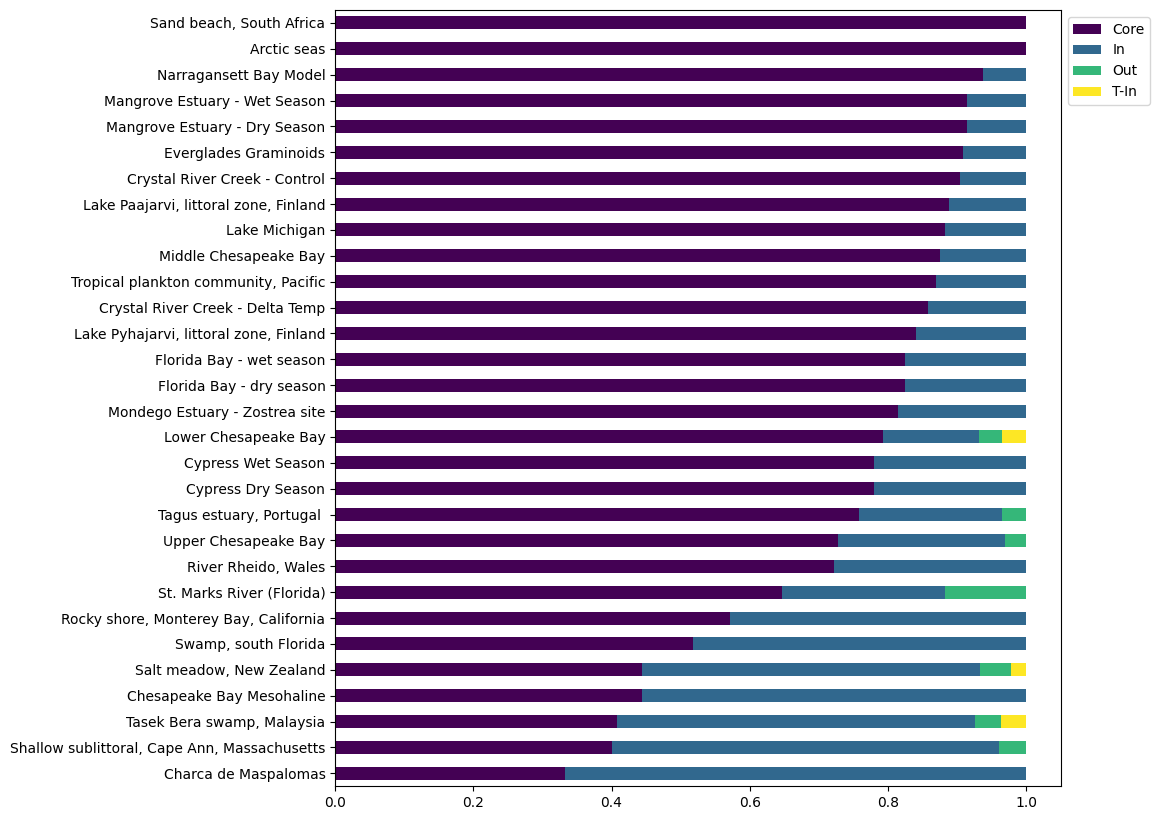

In [80]:
fig, ax = plt.subplots(figsize=(11.7 ,8.3))
network_bowtie_df.sort_values(by='Core', ascending = True).plot(kind = 'barh', stacked = True, layout='constrained', ax=ax, colormap='viridis')
ax.legend(bbox_to_anchor=(1,1))
fig.tight_layout()
out_path = f"{OUT_FOLDER_PAPER}/periphery_structure.pdf"
fig.savefig(out_path)

# Robustness

## Node removal

### Function definition

In [17]:
# Defyining the strategy
class Strategy:
  def __init__(self):
    self._g_test = ig.Graph.Erdos_Renyi(n=10, p=0.2)
    self.strategies = []

  def compile_strat(self, strategy):
    if type(strategy) is not dict:
      print("Strategy must be a dict")
      return False
    keys = strategy.keys()
    if 'name' not in keys:
      print("Strategy must containt these keys: 'name', 'function'")
      return False
    if 'function' not in keys:
      print("Strategy must containt these keys: 'name', 'function'")
      return False

    if type(strategy['name']) is not str:
      print("Strategy name must be a string")
      return False
    if callable(strategy['function']) is False:
      print("Strategy function must be a... uhm... function. Duh!")
      return False

    func = strategy['function']
    return_test = func(self._g_test)
    if type(return_test) is not list or not np.array:
      print("Strategy function should return a list of number")
      return False
    if len(return_test) != self._g_test.vcount():
      print("Strategy function should return a list of number of the same size of the graph")
      return False
    if float(return_test[0]) is not float and not int:
      print("Strategy function should return a list of number")
      return False
    return True

  def compile_and_append(self, strategy):
    exit = self.compile_strat(strategy)
    if exit is False: return
    else: self.strategies.append(strategy)

def node_removal(G, strategies, connectivity_measure_function=connectivity_value, revaluate=True, cut_on_zero=True, verbose=False, norm=True):
  if isinstance(strategies, Strategy) is not True:
    print(f"strategies must {Strategy}")
    return -1, None

  def get_node(G_minus, strategy, all=False, living=False):

    ecos = np.array(G_minus.vs()['ECO'])
    if living is True:
      idx = np.argwhere(ecos == 1)
      nodes = [v for v in G_minus.vs() if v['ECO'] == 1]
    else:
      idx = np.argwhere((ecos == 1) | (ecos == 2))
      nodes = [v for v in G_minus.vs() if v['ECO'] == 1 or v['ECO'] == 2]

    # get the scores according to the strategy
    nodes_scores = list(np.array(strategy['function'](G_minus))[idx].ravel())
    # get the sequence of igraph vertices sorted by their score
    node_sequence = [v['name'] for _, v in sorted(zip(nodes_scores, nodes), reverse=True)]
    if all is True: return node_sequence
    else: return node_sequence[0]

  def get_df_removed(G, strategies, norm, living, revaluate, cut_on_zero, verbose):
    df = []
    columns = ['graph_name', 'strategy', 'node_removed', 'biomass', 'type', 'rank', 'connectivity_measure', 'value']

    if cut_on_zero: test = lambda G: connectivity_measure_function(G)
    else: 
      if living is False: test = lambda G: G.vcount()
      else:
        test = lambda G: len(G.vs.select(lambda vertices: vertices['ECO'] == 1.0))
    # Revaluate is the flag that tells either if revaluating the connectivity measurement according to the strategy for each step or not
    if revaluate is True:
      # Loop on the strategies
      for strategy in strategies.strategies:
        if verbose: print(f"{G['name']} - evaluating {strategy['name']}")
        # Make a copy of the graph: delete_vertices is a "in_place" function.
        G_minus = G.copy()
        # Initiate the rank number
        rank = 0
        # Initiate the rows of th dataset
        rows = []
        # test is made to stop the loop over the graph or not.
        while test(G_minus) > 0:
          # get_node gives us either all the nodes 
          node_name = get_node(G_minus, strategy, living=living, all=False)
          # detect the nodes from the the graph
          vs = G_minus.vs.select(lambda vertex: vertex['name'] == node_name)
          v = vs[0]
          # get its biomass and eco
          biomass = v['Biomass']
          eco = v['ECO']
          # delete the node
          G_minus.delete_vertices(v)
          # evaluate the fraction of f_G of the new graph normalized by its max (when all the nodes are not deleted)
          f_G = connectivity_measure_function(G_minus) / norm
          # add 1 to rank
          rank = rank + 1
          # make the string for the strategy
          strat_str = ' (living)' if living else ''
          # append the data to the dataset
          rows.append((G_minus['name'], strategy['name'] + strat_str, node_name, biomass, eco, rank, connectivity_measure_function.__name__, f_G))

        f_G_max = connectivity_measure_function(G) / norm
        rows.insert(0, (G['name'], strategy['name'] + strat_str, 'No nodes removed', -1, -1, 0, connectivity_measure_function.__name__, f_G_max))
        df.append(pd.DataFrame(rows.copy(), columns=columns))
    else:
      for strategy in strategies.strategies:
        if verbose: print(f"{G['name']} - evaluating {strategy['name']}")
        G_minus = G.copy()
        rank = 0
        rows = []
        node_sequence = get_node(G_minus, strategy, living=living, all=True)
        while test(G_minus) > 0:
          node_name = node_sequence[rank]
          vs = G_minus.vs.select(lambda vertex: vertex['name'] == node_name)
          v = vs[0]
          biomass = v['Biomass']
          eco = v['ECO']
          G_minus.delete_vertices(v)
          f_G = connectivity_measure_function(G_minus) / norm_value
          rank = rank + 1
          strat_str = ' (living)' if living else ''
          rows.append((G_minus['name'], strategy['name'] + strat_str, node_name, biomass, eco, rank, connectivity_measure_function.__name__, f_G))
        
        rows.insert(0, (G['name'], strategy['name'] + strat_str, 'No nodes removed', -1, -1, 0, connectivity_measure_function.__name__, connectivity_measure_function(G)))
        df.append(pd.DataFrame(rows.copy(), columns=columns))
    df = pd.concat(df)
    return df

  if norm: 
    norm_value = connectivity_measure_function(G)
  else:
    norm_value = 1
  df_remove_all = get_df_removed(G, strategies, norm_value, False, revaluate, cut_on_zero, verbose)
  df_remove_living = get_df_removed(G, strategies, norm_value, True, revaluate, cut_on_zero, verbose)
  return df_remove_all, df_remove_living
  
def greedy(G, connectivity_measure_function=connectivity_value):
  conn_greedy = []
  N = G.vcount()
  for i, v in enumerate(G.vs()):
    G_minus_v_greedy = G.copy()
    G_minus_v_greedy.delete_vertices([v])
    conn_greedy.append(-(connectivity_measure_function(G_minus_v_greedy) + i/N))
  return conn_greedy


### Distructive nodes - Greedy Strategy on LN

In [18]:
list_distructive_nodes_G = {}
strats = Strategy()
strats.compile_and_append({'name': 'Greedy', 'function': greedy})
for G in G_dataset:
  # rets = node_removal(G, strats, revaluate=True, cut_on_zero=False, norm=False)
  rets = node_removal(G, strats, revaluate=True, cut_on_zero=False)
  list_distructive_nodes_G[G['name']] = rets[1]['node_removed'].to_list()[1:]
  
out_file_list_nodes = 'destructive_nodes_living_revaluate_f_G_norm.pickle'
with open(os.path.join(OUT_FOLDER_PAPER, out_file_list_nodes), 'wb') as fp:
  pickle.dump(list_distructive_nodes_G, fp)

In [22]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

# Change in connectivity value after node removal for different strategies

<Figure size 830x1170 with 0 Axes>

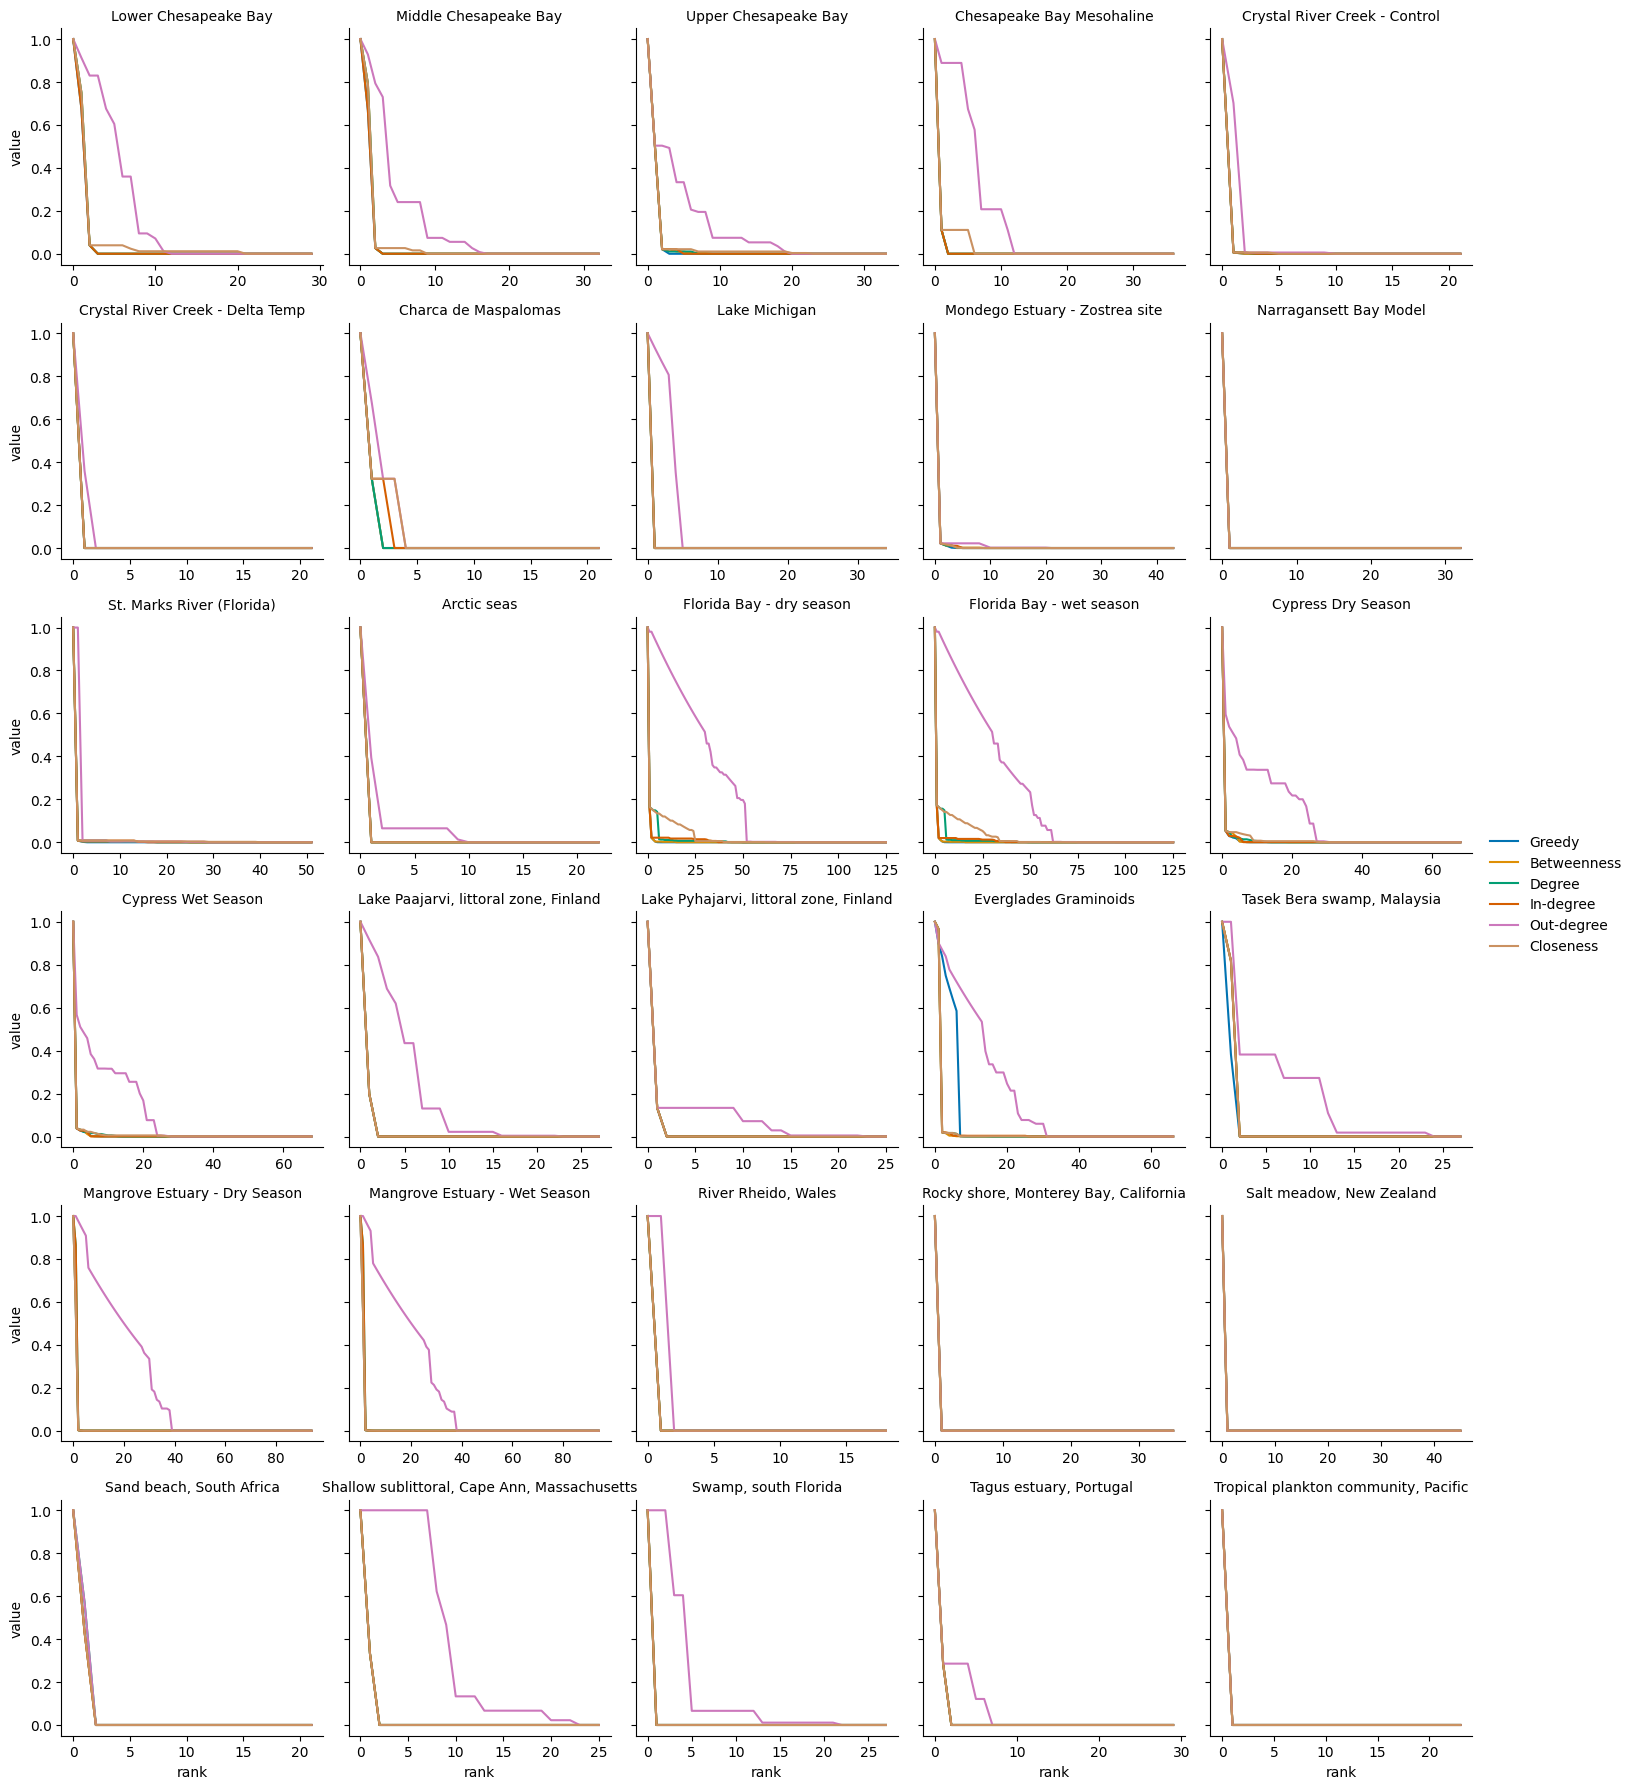

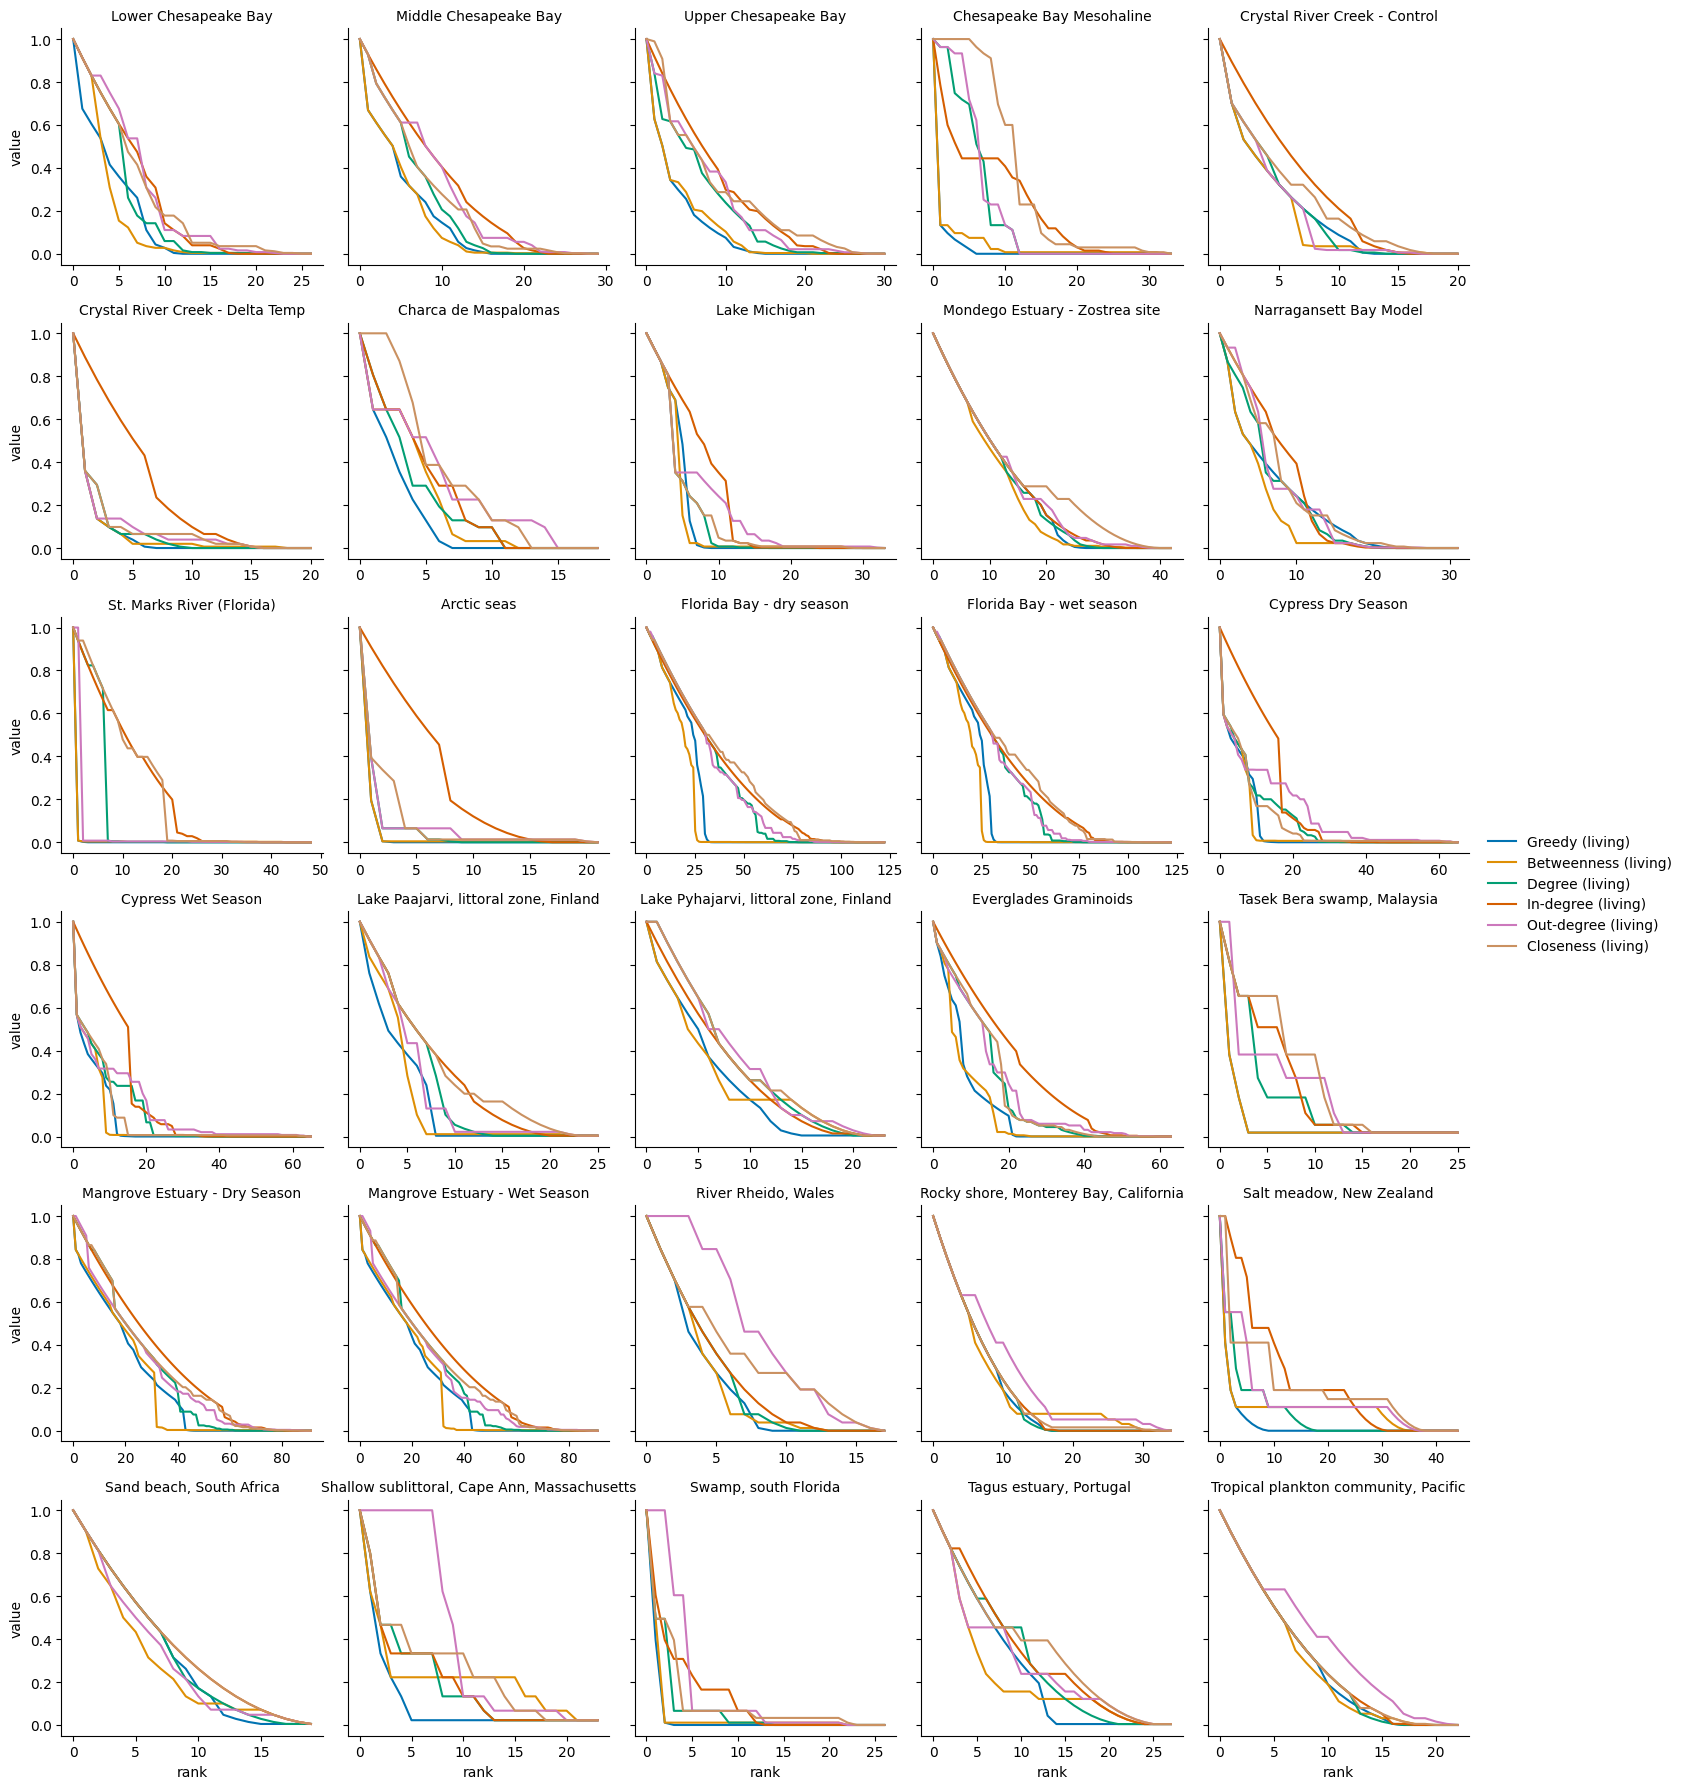

In [24]:
removed_all_nodes_df = []
removed_living_nodes_df = []
strats = Strategy()
strats.compile_and_append({'name': 'Greedy', 'function': greedy})
strats.compile_and_append({'name': 'Betweenness', 'function': lambda G: G.betweenness()})
strats.compile_and_append({'name': 'Degree', 'function': lambda G: G.degree()})
strats.compile_and_append({'name': 'In-degree', 'function': lambda G: G.indegree()})
strats.compile_and_append({'name': 'Out-degree', 'function': lambda G: G.outdegree()})
strats.compile_and_append({'name': 'Closeness', 'function': lambda G: G.closeness()})

for G in G_dataset:
  rets = node_removal(G, strats, revaluate=True, cut_on_zero=False, verbose=False)
  removed_all_nodes_df.append(rets[0])
  removed_living_nodes_df.append(rets[1])

removed_all_nodes_df = pd.concat(removed_all_nodes_df)
removed_living_nodes_df = pd.concat(removed_living_nodes_df)

plt.figure(figsize=(8.3,11.7))

g = sns.FacetGrid(removed_all_nodes_df, col = 'graph_name', col_wrap = 5, sharex=False, aspect=1)
g.map_dataframe(sns.lineplot, x='rank', y='value', hue='strategy', palette='colorblind')
g.set_titles(col_template = "{col_name}")
g.add_legend()
out_file = OUT_FOLDER_SUPP + '/f_G_change_all_nodes_colorblind.pdf'
g.savefig(out_file)

g = sns.FacetGrid(removed_living_nodes_df, col = 'graph_name', col_wrap = 5, sharex=False, aspect=1)
g.map_dataframe(sns.lineplot, x='rank', y='value', hue='strategy', palette='colorblind')
g.set_titles(col_template = "{col_name}")
g.add_legend()
out_file = OUT_FOLDER_SUPP + '/f_G_change_living_nodes_colorblind.pdf'
g.savefig(out_file)

## Robustness functions and their measurements.

We defined:
$\rho_G = \frac{1}{S_G} \sum_i \bigl[ f(G^{(i)}) \big/ f(G) \bigr]$

Where $G^{(i)} = G^{(i-1)} / \{v_i\}$, $v_i$ is the $i$-th node of the greedy sequence for the graph $G$ and $f(G)$ is the connectivity value of the graph G.

In [26]:
def robustness(G, list_of_nodes, connectivity_function=connectivity_value):
  f_G_max = connectivity_function(G)
  G_minus = G.copy()
  f_G = []
  f_G.append(1)
  for node in list_of_nodes:
    G_minus.delete_vertices(node)
    f_G.append(connectivity_function(G_minus) / f_G_max)
  area = np.sum(np.array(f_G))
  rho = area / G.vcount()
  return rho


<ipython-input-30-31431cd06b42>:24: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  _ = sns.heatmap(robustness_df.corr(), annot=True)


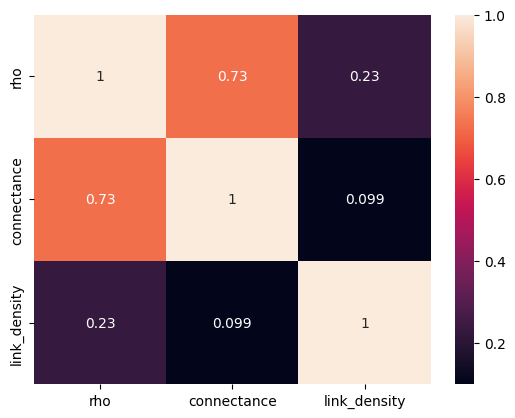

In [30]:
rows = []
for G in G_dataset:
  graph_name = G['name']
  row = []
  row.append(graph_name)
  L = G.ecount()
  S = G.vcount()
  row.append(robustness(G, list_distructive_nodes_G[graph_name]))
  C = L/(S*S)
  d = L/S
  row.append(C)
  row.append(d)
  rows.append(tuple(row))

columns = ['graph_name']
columns.append('rho')
columns.append('connectance')
columns.append('link_density')
robustness_df = pd.DataFrame(rows, columns=columns)

# Evaluating the correlation with Connectance and Link density of the network

robustness_df_rank = robustness_df.copy()
_ = sns.heatmap(robustness_df.corr(), annot=True)

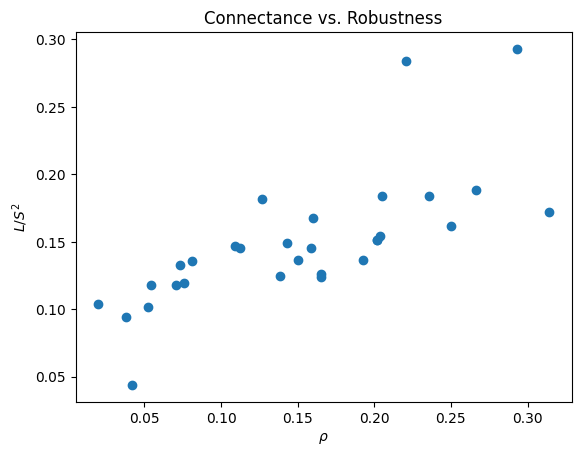

In [32]:
fig, ax = plt.subplots()
ax.scatter(robustness_df['rho'], robustness_df['connectance'])
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$L/S^2$')
ax.set_title("Connectance vs. Robustness")
fig.show()

## Visualization of node delition with the greedy strategy and robustness sort

In [34]:
deletion_df = []
strats = Strategy()
strats.compile_and_append({'name': 'Greedy', 'function': greedy})
for G in G_dataset:
  rets = node_removal(G, strats, revaluate=True, cut_on_zero=False)
  deletion_df.append(rets[1])
  
deletion_df = pd.concat(deletion_df)

In [36]:
rows = []
for graph_name in deletion_df['graph_name'].unique():
  df = deletion_df[deletion_df['graph_name'] == graph_name]
  nodes_top_3 = df[(df['rank'] >= 1) & (df['rank'] <= 3) & (df['strategy'] == 'Greedy (living)')]['node_removed'].to_list()
  robustness = float(robustness_df[robustness_df['graph_name'] == graph_name]['rho'])
  rows.append((graph_name, nodes_top_3, robustness))
top_3_df = pd.DataFrame(rows, columns=['graph_name', 'top_3_nodes', 'rho']).sort_values(by='rho', ascending=False)
# display(top_3_df)
out_file = OUT_FOLDER_PAPER + '/top_3_nodes.xlsx'
top_3_df.to_excel(out_file)
del(df)

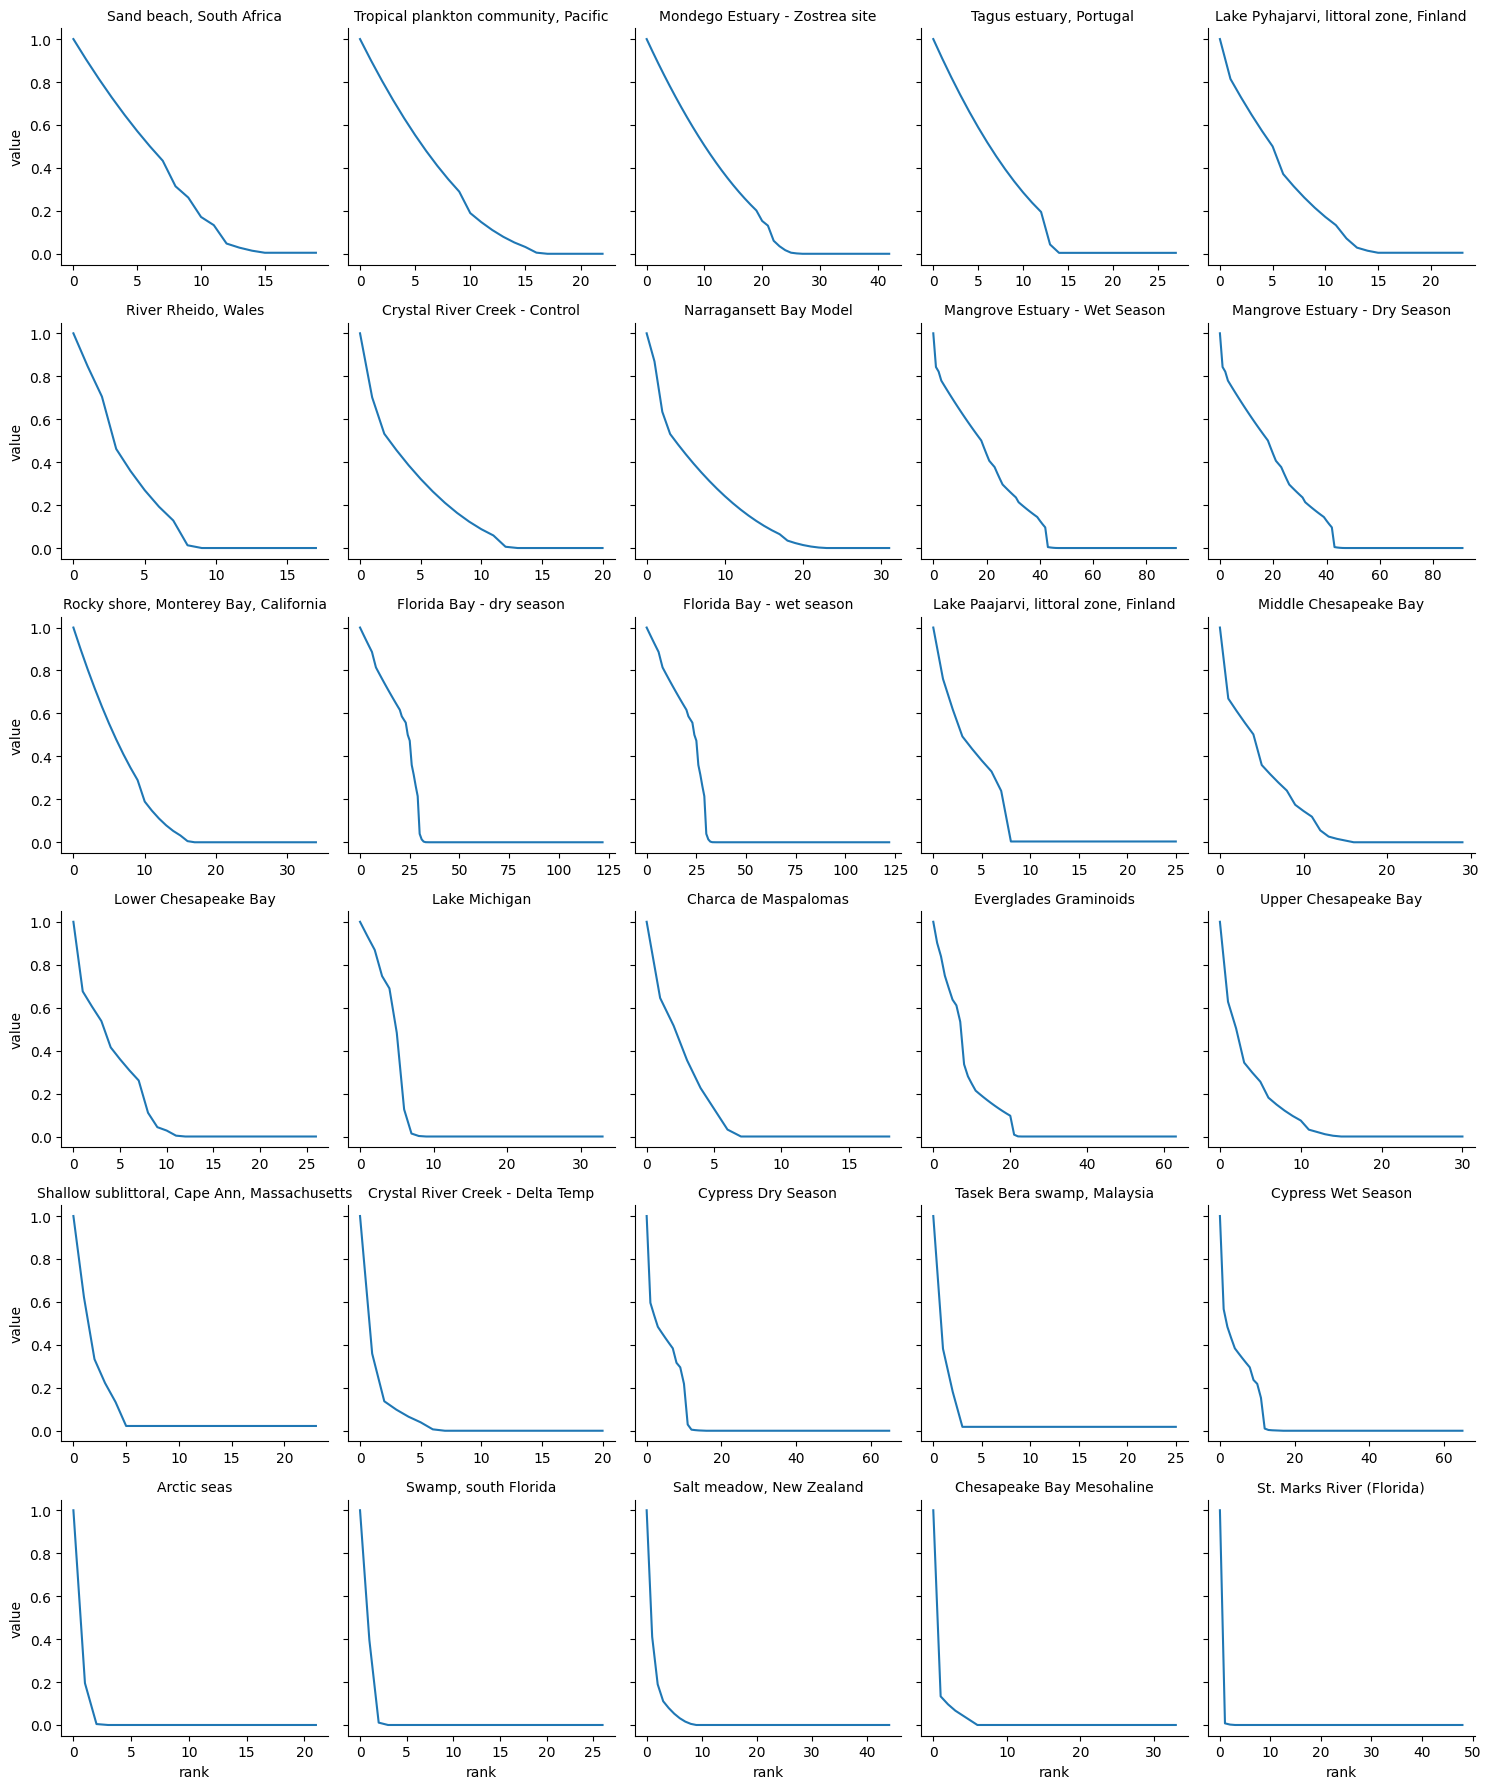

In [38]:
col_order = robustness_df.sort_values(by='rho', ascending=False)['graph_name'].to_list()
deletion_df['value'] = [min(x,1) for x in deletion_df['value'].to_numpy()]
g = sns.FacetGrid(deletion_df, col = 'graph_name', col_wrap = 5, col_order = col_order, sharex=False)
g.map_dataframe(sns.lineplot, x='rank', y='value')
g.set_titles(col_template = "{col_name}")
out_file = OUT_FOLDER_SUPP + '/robustness_sorted.pdf'
g.savefig(out_file)

# Change in SCC

In [41]:
%%capture
import seaborn as sns
from matplotlib.colors import to_hex

n_row = 6
n_cols = len(G_dataset) / n_row
fig_all, axs_all = plt.subplots(6,5, figsize=(8.3,11.7))
id_ax = 0

def scc_colors(G, palette='colorblind'):
  scc_color = list(np.zeros(G.vcount()))
  scc_list = [scc for scc in G.connected_components(mode='strong')]
  scc_no_isolate = [scc for scc in scc_list if len(scc) > 1]
  n_scc = len(scc_no_isolate) + 1
  cmap = sns.color_palette(palette, n_colors=n_scc)
  color_id = -1
  for scc in scc_list:
    len_scc = len(scc)
    if len_scc == 1: color = '#FFFFFF'
    else:
      color_id = color_id + 1
      color = to_hex(cmap[color_id])
    for vertex_id in scc:
      scc_color[int(vertex_id)] = color
  return scc_color

out_folder = OUT_FOLDER_PAPER + '/ridiculogram_scc'
if os.path.exists(out_folder) is False:
  os.mkdir(out_folder)

G_ds_temp = [G_dataset[6]]

for G in G_dataset:
# for G in G_ds_temp:
  # G = G_dataset[0]
  print(G['name'])
  greedy_revaluate = deletion_df[deletion_df['graph_name'] == G['name']]
  G_dump = G.copy()

  # fig, axs = plt.subplots(2,2, figsize=(16,12))
  fig, axs = plt.subplots(figsize=(8,8))
  layout = G.layout()
  vs = visual_style(G_dump, layout=layout)
  vs['vertex_color'] = scc_colors(G_dump)
  scc_sizes = [len(scc) for scc in G_dump.components(mode='strong')]
  max_scc_size = max(scc_sizes)

  ig.plot(G_dump,target = axs, **vs)
  axs.set_title(f"{G['name']}")
  vs['vertex_label'] = None
  i_row = id_ax % n_row
  i_col = id_ax // n_row
  id_ax = id_ax + 1
  ig.plot(G,target = axs_all[i_row, i_col], **vs)
  axs_all[i_row, i_col].set_title(f"{G['name']}", size=4)
  fig.savefig(out_folder + '/' + G['name'] + '.pdf')

out_path = out_path = f"{OUT_FOLDER_SUPP}/scc_colorblind.pdf"
fig_all.tight_layout()
fig_all.savefig(out_path)

del(G_dump)

In [24]:
# !zip /content/change_in_scc/data.zip /content/change_in_scc/*pdf

# Visualizzation of single network

In [25]:
#@title Picking the network
i = 0
for G in G_dataset:
  print(i, G['name'])
  i = i + 1

0 Lower Chesapeake Bay
1 Middle Chesapeake Bay
2 Upper Chesapeake Bay
3 Chesapeake Bay Mesohaline
4 Crystal River Creek - Control
5 Crystal River Creek - Delta Temp
6 Charca de Maspalomas
7 Lake Michigan
8 Mondego Estuary - Zostrea site
9 Narragansett Bay Model
10 St. Marks River (Florida)
11 Arctic seas
12 Florida Bay - dry season
13 Florida Bay - wet season
14 Cypress Dry Season
15 Cypress Wet Season
16 Lake Paajarvi, littoral zone, Finland
17 Lake Pyhajarvi, littoral zone, Finland
18 Everglades Graminoids
19 Tasek Bera swamp, Malaysia
20 Mangrove Estuary - Dry Season
21 Mangrove Estuary - Wet Season
22 River Rheido, Wales
23 Rocky shore, Monterey Bay, California
24 Salt meadow, New Zealand
25 Sand beach, South Africa
26 Shallow sublittoral, Cape Ann, Massachusetts
27 Swamp, south Florida
28 Tagus estuary, Portugal 
29 Tropical plankton community, Pacific


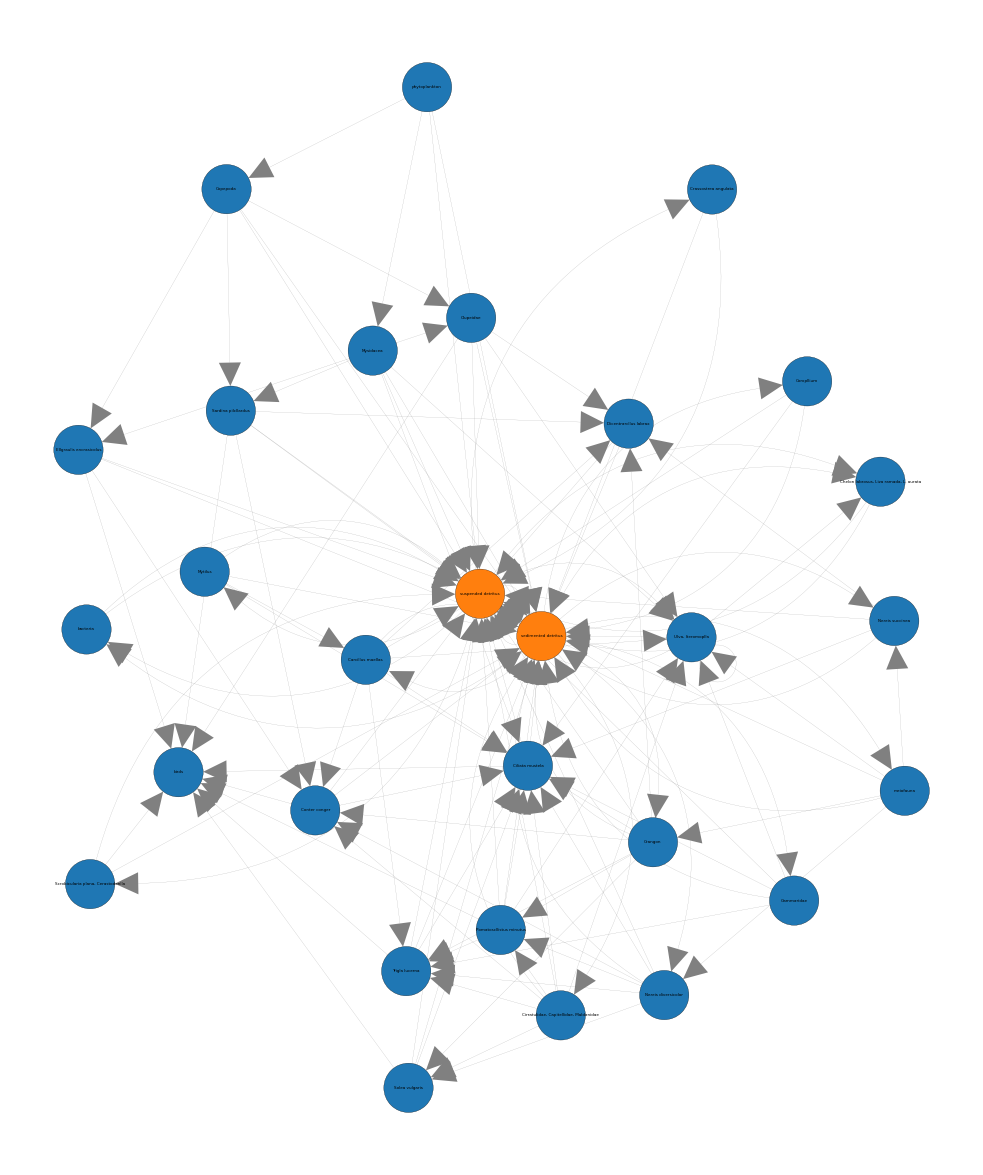

In [26]:
#@title Network visualization
i = 28
G = G_dataset[i]
fig, ax = plt.subplots(figsize=(15,15))

ig.plot(G, target=ax, **visual_style(G))
fig.savefig(f"/content/{G['name']}.pdf")

Degree: 21
In-degree: 20
Out-Degree: 1
Betweenness: 72.88888888888889


<Axes: >

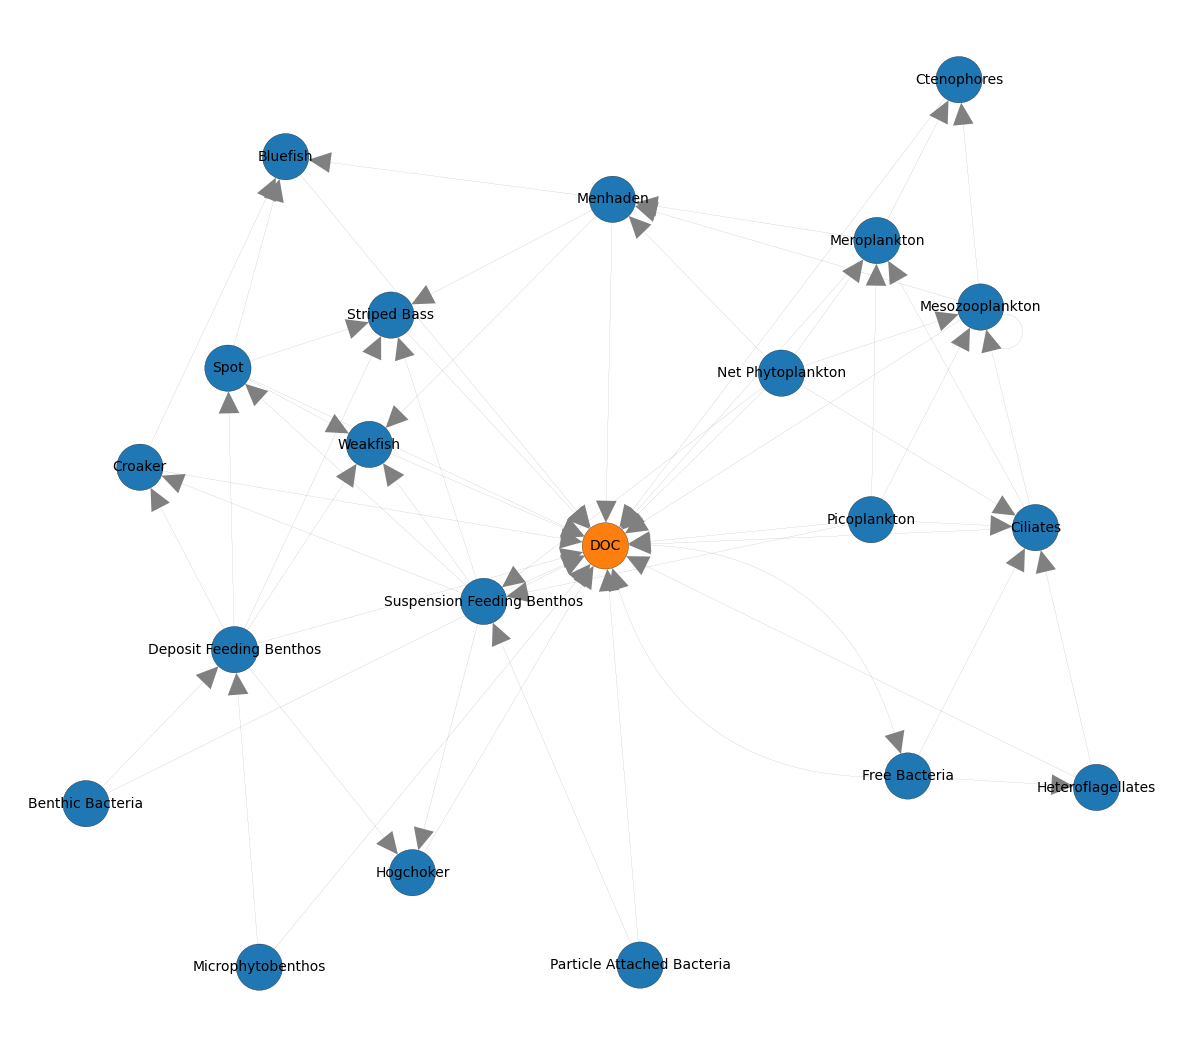

In [42]:
def ego_net(G, node_name):
  nodes = G.neighbors(node_name)
  for v in G.vs():
    if v['name'] == node_name:
      node_id = v.index
      node = v
      break
  nodes.append(node_id)
  print(f'Degree: {node.degree()}')
  print(f'In-degree: {node.indegree()}')
  print(f'Out-Degree: {node.outdegree()}')
  print(f'Betweenness: {node.betweenness()}')
  # Remove duplicates
  nodes = list(dict.fromkeys(nodes))
  return G.subgraph(nodes)

G = G_dataset[0]
G_s = ego_net(G, 'DOC')

fig, ax = plt.subplots(figsize=(15,15))
vs = visual_style(G_s)
vs['vertex_label_size'] = 10
ig.plot(G_s, target=ax, **vs)

# Removed nodes: common features

In [43]:
n_nodes = 3
strats = Strategy()
strats.compile_and_append({'name': 'Greedy', 'function': greedy})

nodes_df = []

for G in G_dataset:
  nodes_name = node_removal(G, strats, revaluate=True, cut_on_zero=False)[1]['node_removed'].to_list()[1:n_nodes+1]
  vertices = [v for v in G.vs() if v['name'] in nodes_name]
  indegrees = G.indegree()
  outdegrees = G.outdegree()
  node_data_G = pd.DataFrame()
  rows = []
  columns = ['graph_name', 'node_name', 'rank', 'indegree', 'outdegree', 'GenSD', 'VulSD', 'in_frac', 'out_frac']
  S = G.vcount()
  L = G.ecount()
  c = L/S
  for i, node in enumerate(vertices):
    row = []
    row.append(G['name'])
    row.append(node['name'])
    rank = i + 1
    row.append(rank)
    id = node.index
    row.append(indegrees[id])
    row.append(outdegrees[id])
    row.append(indegrees[id]/c)
    row.append(outdegrees[id]/c)
    row.append(indegrees[id]/S)
    row.append(outdegrees[id]/S)
    rows.append(tuple(row))

  nodes_df.append(pd.DataFrame(rows, columns=columns))

nodes_df = pd.concat(nodes_df)

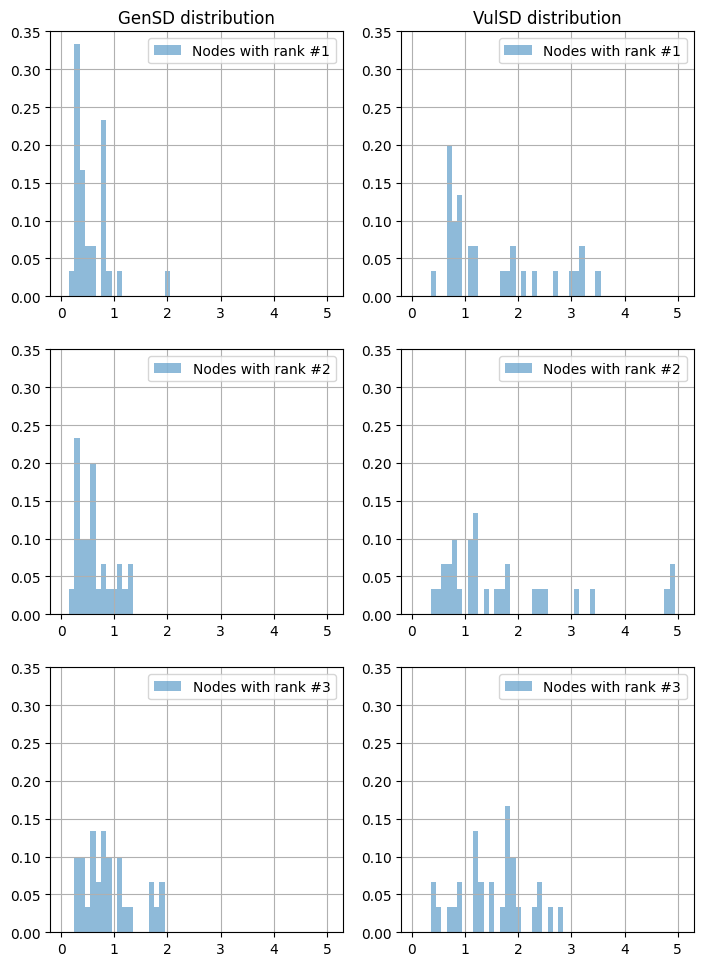

In [45]:
def hist_freq(ax, x, bins, **kwargs):
    counts, bins = np.histogram(x, bins=bins)
    counts_norm = counts/np.sum(counts)
    width = bins[1] - bins[0]
    ax.bar(bins[1:], counts_norm, width=width, **kwargs)

round_factor = 1
max_gen = max(nodes_df['GenSD'])
max_vul = max(nodes_df['VulSD'])
max_val = max(max_vul, max_gen)
max_val = (max_val + round_factor) // round_factor * round_factor
bins = np.linspace(0,max_val,num=51)
fig, axs = plt.subplots(n_nodes,2, figsize = (8.3 ,11.7))
# Retrieve the maximum y value among the plots in order to ensure a consistent scale
y_max = None

for i in range(1,n_nodes+1):
  GenSD = nodes_df[nodes_df['rank'] == i]['GenSD'].to_numpy()
  VulSD = nodes_df[nodes_df['rank'] == i]['VulSD'].to_numpy()
  hist_freq(axs[i-1, 0], GenSD, bins, label = f'Nodes with rank #{i}', alpha = 0.5)
  hist_freq(axs[i-1, 1], VulSD, bins, label = f'Nodes with rank #{i}', alpha = 0.5)
  if y_max is None: y_max = max(axs[i-1, 0].get_ylim()[1], axs[i-1, 1].get_ylim()[1]) 
  else: y_max = max(y_max, axs[i-1, 0].get_ylim()[1], axs[i-1, 1].get_ylim()[1]) 
axs[0, 0].set_title('GenSD distribution')
axs[0, 1].set_title('VulSD distribution')
round_factor = 0.05
y_max = (y_max + round_factor) // round_factor * round_factor
for ax in axs.reshape(-1):
  ax.set_ylim(0, y_max)
  ax.grid()
  ax.legend()

fig.savefig("/content/gensd_vulsd.pdf")

# Network visualizzations

## Select Dataset

In [36]:
G = G_dataset[16]
print(f"{G['name']} selected")

Lake Paajarvi, littoral zone, Finland selected


## Whole network with *destructive* nodes in red

In [37]:
def get_n_distructive_nodes(nodes_df, name):
  graph_df = nodes_df[nodes_df['graph_name'] == name]
  nodes = graph_df['node_name'].to_list()
  return nodes

nodes = get_n_distructive_nodes(nodes_df, G['name'])
vs = visual_style(G)
vs['vertex_color'] = [c[0] if c[1] not in nodes else '#DA3B28' for c in zip(vs['vertex_color'], G.vs['name'])]
vs['vertex_label_size'] = 3
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title(G['name'])
ig.plot(G, target=ax, **vs)

fig.savefig(f"{OUT_FOLDER_PAPER}/{G['name']} nodes removed.pdf")

## *Distructive* nodes ego net

In [38]:
n_nodes = len(nodes)
fig, axs = plt.subplots(1, n_nodes, figsize=(11.7,8.3))

for i, node in enumerate(nodes):
  G_s = ego_net(G, node)

  vs = visual_style(G_s)
  vs['vertex_label_size'] = 5
  for j, el in enumerate(zip(vs['vertex_label'], vs['vertex_color'])):
    if el[0] == node: vs['vertex_color'][j] = '#DA3B28'
  ig.plot(G_s, target=axs[i], **vs)
  axs[i].set_title(f"{G['name']}: {node}")
fig.tight_layout()
fig.savefig(f"{OUT_FOLDER_PAPER}/{G['name']} nodes removed ego nets.pdf")

## Detriti ego net

In [39]:
detriti_nodes = [v['name'] for v in G.vs() if v['ECO'] == 2]
n_nodes = len(detriti_nodes)
fig, axs = plt.subplots(2, n_nodes, figsize=(11.7,8.3))

for i, node in enumerate(detriti_nodes):
  # get node id
  for v in G.vs():
    if v['name'] == node:
      node_index = v.index
      break
  # in ego net
  nodes_in = G.neighbors(node, mode='in')
  # out ego net
  nodes_out = G.neighbors(node, mode='out')
  nodes_in.append(node_index)
  nodes_out.append(node_index)
  In = G.subgraph(nodes_in)
  Out = G.subgraph(nodes_out)
  for G_id, el in enumerate(zip([In, Out], ['in set', 'out set'])):
    ax = axs[G_id][i]
    label = el[1]
    G_s = el[0]
    vs = visual_style(G_s)
    vs['vertex_label_size'] = 5
    ig.plot(G_s, target=ax, **vs)
    ax.set_title(f"{G['name']}: {node} {label}")
fig.tight_layout()
fig.savefig(f"{OUT_FOLDER_PAPER}/{G['name']} detriti ego nets.pdf")

## Whole network dataset

In [40]:
%%capture
out_folder = OUT_FOLDER_PAPER + '/ridiculogram_whole/'
if os.path.exists(out_folder) is False:
  os.mkdir(out_folder)

for G in G_dataset:
  fig, ax = plt.subplots(figsize=(15,15))

  ig.plot(G, target=ax, **visual_style(G))
  ax.set_title(G['name'])
  out_path = f"{out_folder}{G['name']}.pdf"

  print(f"Saving in {out_path}")
  fig.savefig(out_path)

# Bow-Tie visualization

In [69]:
#@title Bow-tie Visualizzation
%%capture
out_folder = OUT_FOLDER_PAPER + '/ridiculogram_structure/'

if os.path.exists(out_folder) is False:
  os.mkdir(out_folder)

n_row = 6
n_col = 5
fig_all, axs = plt.subplots(6,5, figsize=(8.3,11.7))
id_ax = 0
for G in G_dataset:
  components = get_bowtie_structure(G)
  G.vs['bowtie'] = [None for _ in G.vs()]
  for key in components:
    vert_seq = components[key]
    for v in vert_seq:
      G.vs[v]['bowtie'] = key

  fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
  bow_tie_col_dict = {
    'Core': sns.color_palette('colorblind')[0],
    'IN set': sns.color_palette('colorblind')[1],
    'OUT set': sns.color_palette('colorblind')[2],
    'Tubes': sns.color_palette('colorblind')[4],
    'Tendrils IN': sns.color_palette('colorblind')[3],
    'Tendrils OUT': sns.color_palette('colorblind')[5],
    'Disconnected set': sns.color_palette('colorblind')[6],
  }
  vs = visual_style(G)
  vs['vertex_color'] = [bow_tie_col_dict[v['bowtie']] for v in G.vs()]
  ig.plot(G,target = ax, **vs)
  vs['vertex_label'] = None
  i_row = id_ax % n_row
  i_col = id_ax // n_row
  id_ax = id_ax + 1
  ig.plot(G,target = axs[i_row, i_col], **vs)
  axs[i_row, i_col].set_title(f"{G['name']}", size=4)
  ax.set_title(f"{G['name']} - Graph structure by role")
  out_path = f"{out_folder}{G['name']}.pdf"
  # print(f"Saving in {out_path}")
  fig.savefig(out_path)

out_path = out_path = f"{OUT_FOLDER_SUPP}/bow_ties_colorblind.pdf"
fig_all.tight_layout()
fig_all.savefig(out_path)

# Differences between graphs

In [45]:
for i, G in enumerate(G_dataset):
  print(i, G['name'])

0 Lower Chesapeake Bay
1 Middle Chesapeake Bay
2 Upper Chesapeake Bay
3 Chesapeake Bay Mesohaline
4 Crystal River Creek - Control
5 Crystal River Creek - Delta Temp
6 Charca de Maspalomas
7 Lake Michigan
8 Mondego Estuary - Zostrea site
9 Narragansett Bay Model
10 St. Marks River (Florida)
11 Arctic seas
12 Florida Bay - dry season
13 Florida Bay - wet season
14 Cypress Dry Season
15 Cypress Wet Season
16 Lake Paajarvi, littoral zone, Finland
17 Lake Pyhajarvi, littoral zone, Finland
18 Everglades Graminoids
19 Tasek Bera swamp, Malaysia
20 Mangrove Estuary - Dry Season
21 Mangrove Estuary - Wet Season
22 River Rheido, Wales
23 Rocky shore, Monterey Bay, California
24 Salt meadow, New Zealand
25 Sand beach, South Africa
26 Shallow sublittoral, Cape Ann, Massachusetts
27 Swamp, south Florida
28 Tagus estuary, Portugal 
29 Tropical plankton community, Pacific


In [46]:
graphs_similar_list = [
    [G_dataset[12], G_dataset[13]],
    [G_dataset[14], G_dataset[15]],
    [G_dataset[20], G_dataset[21]]
    ]

## Vertices differences in GSCC

In [47]:
out_file = OUT_FOLDER_PAPER + '/vertex_diff.dat'
f = open(out_file, 'w')
for graphs in graphs_similar_list:
  N_graphs = len(graphs)
  print("Test on:")
  for g in graphs:
    print(g['name'])

  graphs_vertices = []
  for G in graphs:
    components = get_bowtie_structure(G)
    G.vs['bowtie'] = [None for _ in G.vs()]
    for key in components:
      vert_seq = components[key]
      for v in vert_seq:
        G.vs[v]['bowtie'] = key

    nodes_gscc = [v['name'] for v in G.vs() if v['bowtie'] == 'Core']
    G_gscc = G.subgraph(nodes_gscc)
    G_vertices = set()
    for v in G_gscc.vs():
      G_vertices.add(v['name'])
    graphs_vertices.append(G_vertices)

  f.write(f"{'-'*50}\n")
  f.write("Sym. difference on the vertices of the Core of these graphs:\n")
  for k in range(N_graphs):
    V_core = len([v for v in graphs[k].vs() if v['bowtie'] == 'Core'])
    f.write(f"{graphs[k]['name']}: V_core = {V_core}\n")
  for i in range(N_graphs):
    for j in range(i+1, N_graphs):
      f.write(f"V({graphs[i]['name']}) ∩ V({graphs[j]['name']})\n")
      f.write(f"\t{graphs_vertices[i].intersection(graphs_vertices[j])}")
      f.write(f" TOT: {len(graphs_vertices[i].intersection(graphs_vertices[j]))}\n")
      f.write(f"V({graphs[i]['name']}) / V({graphs[j]['name']})\n")
      f.write(f"\t{graphs_vertices[i].difference(graphs_vertices[j])}")
      f.write(f" TOT: {len(graphs_vertices[i].difference(graphs_vertices[j]))}\n")
      f.write(f"V({graphs[j]['name']}) / V({graphs[i]['name']})\n")
      f.write(f"\t{graphs_vertices[j].difference(graphs_vertices[i])}")
      f.write(f" TOT: {len(graphs_vertices[j].difference(graphs_vertices[i]))}\n\n")

f.close()

Test on:
Florida Bay - dry season
Florida Bay - wet season
Test on:
Cypress Dry Season
Cypress Wet Season
Test on:
Mangrove Estuary - Dry Season
Mangrove Estuary - Wet Season


## Edges difference in Core

In [48]:
out_file = OUT_FOLDER_PAPER + '/edges_diff.dat'
f = open(out_file, 'w')

for graphs in graphs_similar_list:
  N_graphs = len(graphs)
  print("Test on:")
  for g in graphs:
    print(g['name'])
  graphs_edges = []
  for G in graphs:
    components = get_bowtie_structure(G)
    G.vs['bowtie'] = [None for _ in G.vs()]
    for key in components:
      vert_seq = components[key]
      for v in vert_seq:
        G.vs[v]['bowtie'] = key

    nodes_gscc = [v['name'] for v in G.vs() if v['bowtie'] == 'Core']
    G_gscc = G.subgraph(nodes_gscc)
    G_edges = set()
    for e in G_gscc.es():
      G_edges.add((G.vs['name'][e.source], G.vs['name'][e.target]))
    graphs_edges.append(G_edges)

  f.write(f"{'-'*50}\n")
  f.write("Sym. difference on the edges of the Core of these graphs:\n")
  for k in range(N_graphs):
    f.write(f"{graphs[k]['name']}: V = {graphs[k].vcount()}, E = {graphs[k].ecount()}\n")
  for i in range(N_graphs):
    for j in range(i+1, N_graphs):
      f.write(f"E({graphs[i]['name']}) ∩ E({graphs[j]['name']})\n")
      f.write(f"\t{graphs_edges[i].intersection(graphs_edges[j])}\n")
      f.write(f"E({graphs[i]['name']}) / E({graphs[j]['name']})\n")
      f.write(f"\t{graphs_edges[i].difference(graphs_edges[j])}\n")
      f.write(f"E({graphs[j]['name']}) / E({graphs[i]['name']})\n")
      f.write(f"\t{graphs_edges[j].difference(graphs_edges[i])}\n\n")
f.close()

Test on:
Florida Bay - dry season
Florida Bay - wet season
Test on:
Cypress Dry Season
Cypress Wet Season
Test on:
Mangrove Estuary - Dry Season
Mangrove Estuary - Wet Season


In [49]:
rows_core_gen = []
for G in G_dataset:

  components = get_bowtie_structure(G)
  G.vs['bowtie'] = [None for _ in G.vs()]
  for key in components:
    vert_seq = components[key]
    for v in vert_seq:
      G.vs[v]['bowtie'] = key

  L = G.ecount()
  S = G.vcount()
  # v_bio = [v for v in G.vs() if v['ECO'] == 1.0]
  # G_sub_bio = G.subgraph(v_bio)
  # L_L = G_sub_bio.ecount()
  # S_L = G_sub_bio.vcount()
  avg_deg = L/S
  genSD_bowtie = []
  rows = []
  for v in G.vs():
    if v['ECO'] == 1.0:
      genSD = v.indegree() / avg_deg
      vulSD = v.outdegree() / avg_deg
      rows.append((v['name'], genSD, vulSD, v['bowtie']))

  df = pd.DataFrame(rows, columns=['node name', 'GenSD', 'VulSD', 'structure'])
  df_core = df[df['structure'] == 'Core']
  S_core = df_core.shape[0]
  S_gen = df_core[df_core['GenSD'] > 1].shape[0]
  if S_core == 0: frac = 0
  else: frac = S_gen/S_core
  rows_core_gen.append((G['name'], frac))

df = pd.DataFrame(rows_core_gen, columns=['Graph name', 'Gen > 1 fraction in Core'])
out_file = OUT_FOLDER_PAPER + '/core_gen_fraction.csv'
df.to_csv(out_file)

# Gen nodes count

In [49]:
rows_core_gen = []
in_out_df = []
for G in G_dataset:

  components = get_bowtie_structure(G)
  G.vs['bowtie'] = [None for _ in G.vs()]
  for key in components:
    vert_seq = components[key]
    for v in vert_seq:
      G.vs[v]['bowtie'] = key

  L = G.ecount()
  S = G.vcount()
  avg_deg = L/S
  gen_bowtie = []
  rows = []
  for v in G.vs():
    ind = v.indegree()
    gen = v.indegree() / avg_deg
    vul = v.outdegree() / avg_deg
    rows.append((G['name'], v['name'], v['ECO'], ind, gen, vul, v['bowtie']))

  df = pd.DataFrame(rows, columns=['graph name', 'node name', 'eco', 'In degree', 'Gen', 'Vul', 'structure'])
  in_out_df.append(df)

del(df)
in_out_df = pd.concat(in_out_df)

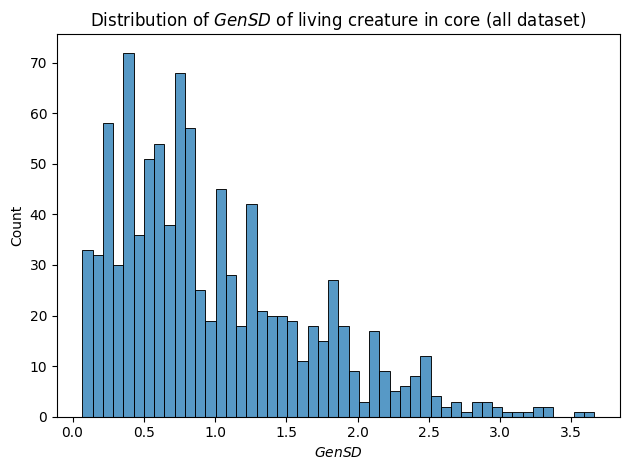

In [50]:
fig, ax = plt.subplots()
df = in_out_df[(in_out_df['structure'] == 'Core') & (in_out_df['eco'] == 1)]
sns.histplot(df, x='Gen', ax=ax, bins=50)
ax.set_title(r"Distribution of $GenSD$ of living creature in core (all dataset)")
ax.set_xlabel(r"$GenSD$")
fig.tight_layout()
out_file = OUT_FOLDER_PAPER + '/gen_distr.pdf'
fig.savefig(out_file)

In [54]:
rows = []
for graph_name in in_out_df['graph name'].unique():
  df = in_out_df[in_out_df['graph name'] == graph_name]
  S_core = df[df['structure'] == 'Core'].shape[0]
  S_gen_bio = df[(df['structure'] == 'Core') & (df['eco'] == 1) & (df['Gen'] >= 1)].shape[0]
  rows.append((graph_name, S_gen_bio / S_core))

gen_bio_df = pd.DataFrame(rows, columns=['Graph name', 'fraction of living nodes with Gen_L >= 1'])
out_file = OUT_FOLDER_PAPER + '/genSD_core.xlsx'
gen_bio_df.sort_values(by='fraction of living nodes with Gen_L >= 1').to_excel(out_file)

In [55]:
rows = []
for graph_name in in_out_df['graph name'].unique():
  df = in_out_df[in_out_df['graph name'] == graph_name]
  indegs_mean = np.mean(df['In degree'].to_numpy())
  indegs_core_mean = np.mean(df[df['structure'] == 'Core']['In degree'].to_numpy())
  indegs_core_in_periphery = np.mean(df[df['structure'] == 'IN set']['In degree'].to_numpy())
  rows.append((graph_name, indegs_mean, indegs_core_mean, indegs_core_in_periphery))

in_degree_df = pd.DataFrame(rows, columns=['Graph name', 'Mean In Degree', 'Mean In Degree - Core', 'Mean In Degree - IN Set'])
out_file = OUT_FOLDER_PAPER + '/in_degree.xlsx'
in_degree_df.to_excel(out_file)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [56]:
rows = []
for graph_name in in_out_df['graph name'].unique():
  df = in_out_df[in_out_df['graph name'] == graph_name]
  indegs_mean = np.mean(df['In degree'].to_numpy())
  indegs_core_mean = np.mean(df[df['structure'] == 'Core']['In degree'].to_numpy())
  indegs_core_in_periphery = np.mean(df[df['structure'] == 'IN set']['In degree'].to_numpy())
  rows.append((graph_name, indegs_mean, indegs_core_mean, indegs_core_in_periphery))

in_degree_df = pd.DataFrame(rows, columns=['Graph name', 'Mean In Degree', 'Mean In Degree - Core', 'Mean In Degree - IN Set'])
out_file = OUT_FOLDER_PAPER + '/in_degree.xlsx'
in_degree_df.to_excel(out_file)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [52]:
rows = []
for graph_name in in_out_df['graph name'].unique():
  df = in_out_df[in_out_df['graph name'] == graph_name]
  N_core = df[df['structure'] == 'Core'].shape[0]
  N_In = df[df['structure'] == 'IN set'].shape[0]
  N_Out = df[df['structure'] == 'OUT set'].shape[0]
  N_tendrils_in = df[df['structure'] == 'Tendrils IN'].shape[0]
  N_core_gen_more_one = df[(df['structure'] == 'Core') & (df['Gen'] > 1)].shape[0]
  N_In_gen_more_one = df[(df['structure'] == 'IN set') & (df['Gen'] > 1)].shape[0]
  N_Out_gen_more_one = df[(df['structure'] == 'OUT set') & (df['Gen'] > 1)].shape[0]
  N_tendrils_in_gen_more_one = df[(df['structure'] == 'Tendrils IN') & (df['Gen'] > 1)].shape[0]
  rows.append((graph_name, N_core, N_In, N_Out, N_tendrils_in, N_core_gen_more_one, N_In_gen_more_one, N_Out_gen_more_one, N_tendrils_in_gen_more_one))
gen_df = pd.DataFrame(rows, columns=['Graph name', 'N Core', 'N In', 'N Out', 'N TIn', 'N Core Gen', 'N In Gen', 'N Out Gen', 'N TIn Gen'])
display(gen_df)
out_file = OUT_FOLDER_PAPER + '/gen_count_structure.xlsx'
gen_df.to_excel(out_file)

,Graph name,N Core,N In,N Out,N TIn,N Core Gen,N In Gen,N Out Gen,N TIn Gen
0,Lower Chesapeake Bay,23,4,1,1,14,0,0,0
1,Middle Chesapeake Bay,28,4,0,0,11,0,0,0
2,Upper Chesapeake Bay,24,8,1,0,11,1,0,0
3,Chesapeake Bay Mesohaline,16,20,0,0,6,9,0,0
4,Crystal River Creek - Control,19,2,0,0,7,0,0,0
5,Crystal River Creek - Delta Temp,18,3,0,0,7,0,0,0
6,Charca de Maspalomas,7,14,0,0,4,4,0,0
7,Lake Michigan,30,4,0,0,10,0,0,0
8,Mondego Estuary - Zostrea site,35,8,0,0,16,0,0,0
9,Narragansett Bay Model,30,2,0,0,12,0,0,0
